In [1]:
import numpy as np
import importlib
import calibration
importlib.reload(calibration)
import tensorflow as tf
from tensorflow import keras
from keras import layers
import sklearn
import sklearn.metrics
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()


2022-11-27 22:21:16.165057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 22:21:16.246960: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-27 22:21:16.249190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 22:21:16.249200: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_train[..., np.newaxis]
x_train = x_train[..., np.newaxis]
y_test = y_test[..., np.newaxis]
y_train = y_train[..., np.newaxis]

def group_in_two(y):
    y[y < 5] = 0
    y[y >= 5] = 1

group_in_two(y_train)
group_in_two(y_test)


In [36]:
input_shape = x_train.shape[1:3]
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(),
    layers.Dense(2, activation=keras.activations.relu),
    layers.Dense(4, activation=keras.activations.relu),
    layers.Dense(4, activation=keras.activations.relu),
    layers.Dense(4, activation=keras.activations.relu),
    layers.Dense(4, activation=keras.activations.relu),
    layers.Dense(1, activation=keras.activations.sigmoid),
    ]
)
def loss_func(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = y_true[:, 0]
    eps = 1e-6
    p0 = tf.clip_by_value(1 - y_pred[:,0] + eps, 0, 1)
    p1 = tf.clip_by_value(y_pred[:,0] + eps, 0, 1)
    loss = -tf.math.xlogy(y_true, p1) - tf.math.xlogy(1 - y_true, p0)
    loss /= tf.math.log(2.0)
    return loss

optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss=loss_func, optimizer=optimizer)


In [41]:
model.optimizer.learning_rate = 0.0011
model.fit(x_train, y_train, batch_size=60000, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 67ms/step - loss: 0.7877
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 0.8726
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 1.2889
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 0.7815
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 0.7793
Epoch 6/100
1/1 [==============================] - 0s 37ms/step - loss: 0.7773
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.7754
Epoch 8/100
1/1 [==============================] - 0s 39ms/step - loss: 0.7737
Epoch 9/100
1/1 [==============================] - 0s 40ms/step - loss: 0.7724
Epoch 10/100
1/1 [==============================] - 0s 42ms/step - loss: 0.7718
Epoch 11/100
1/1 [==============================] - 0s 40ms/step - loss: 0.7721
Epoch 12/100
1/1 [==============================] - 0s 37ms/step - loss: 0.7770
Epoch 13/100
1/1 [==============================]

In [20]:
y_pred = model(x_train).numpy()
scores = y_pred[:, 0]
y_pred_bin = scores >= 0.5
loss = loss_func(y_train, y_pred).numpy()
np.average(loss)

0.48077837

In [21]:
sklearn.metrics.accuracy_score(y_train, y_pred_bin)

0.87445

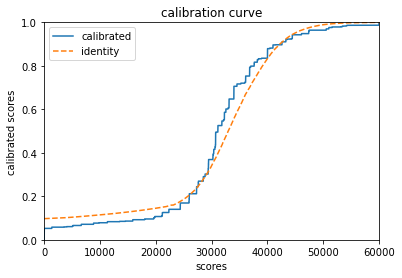

0.4622363

In [22]:
calibration.get_binary_entropy(y_train)
calib_scores = calibration.get_calibrated_scores(y_train.squeeze(1), scores)
calibration.plot_calibrated_curve(scores, calib_scores)
y_pred_calib = calib_scores[:, np.newaxis]
loss_calib = loss_func(y_train, y_pred_calib)
np.average(loss_calib)


In [210]:
w = model.weights
w0 = w[0].numpy()
w1 = w[1].numpy()